# Overview

In this notebook, we aim to reproduce the model from [_Zimonyan & Zisserman 2015_](https://arxiv.org/pdf/1409.1556v6.pdf). In other words, we will design an analogous model on TensorFlow, train it with the data from the [ImageNet Object Classification Challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge) and ultimately benchmark its performance with the original model.

In [1]:
# Import packages

# Data analysis
import numpy as np
import pandas as pd

# File management
import os
import shutil

# Image processing
import matplotlib.pyplot as plt
from skimage.io import imread
import skimage.transform as sktr

# Neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers
tf.keras.utils.set_random_seed(123)

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


Here we list the constants that will be used for preprocessing and model design.

In [3]:
# Define constants

# Set number of classes to use (this is a way to subset the data)
CLASS_NUM = 3
# Set batch size for mini-batch gradient descent
BATCH_SIZE = 256
#BATCH_SIZE = 256

# Set kernel size for Conv2D layers
KERNEL_SIZE = 3
# Set padding mode for Conv2D layers
PAD_MODE = "same"
# Set activation function for Conv2D layers
ACTIVATION = "relu"

# Set pool size for MaxPool2D layers
POOL_SIZE = 2
# Set strides for MaxPool2D layers
POOL_STRIDES = 2

# Data Preprocessing

Because the train set is big (`train_dir`), we take a subset of classes defined by `CLASS_NUM` and copy the images belonging to that subset of classes to our working directory (`subset_dir`). Initially, we will train the model using only this subset.

In [4]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge"
train_dir = base_dir + "/ILSVRC/Data/CLS-LOC/train"
subset_dir = "/kaggle/working/data"

if not os.path.exists(subset_dir):
    os.mkdir(subset_dir)
    print(subset_dir, "created!")
else:
    print(subset_dir, "already exists!")
    
# Select only first n class dirs
class_dirs = os.listdir(train_dir)[:CLASS_NUM]

# Copy class dir from train set to working dir
for class_dir in class_dirs:
    # Define current source and destination paths
    source_dir = train_dir + "/" + class_dir
    destination_dir = subset_dir + "/" + class_dir
    
    # If new class, copy to working dir
    if not os.path.exists(destination_dir):
        shutil.copytree(source_dir, destination_dir)
        print(class_dir, "succesfully copied!")
    # If it exists, don't copy again
    else:
        print(class_dir, "doesn't need copying!")

/kaggle/working/data created!
n01531178 succesfully copied!
n02412080 succesfully copied!
n02098413 succesfully copied!


In [5]:
print(class_dirs)

['n01531178', 'n02412080', 'n02098413']


Now that the images were copied in our working directory, we try to open one as a sanity check. Which animal did you find?

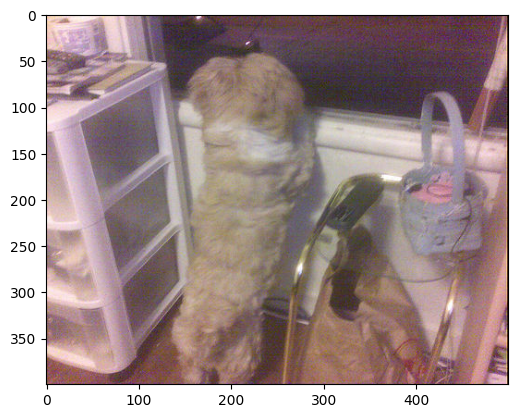

In [6]:
# Read in image
image = imread(subset_dir + "/n02098413/n02098413_720.JPEG")
# Show image
plt.imshow(image)

Then, we import our train set with keras utils. We are now ready to use it to train a model!

In [7]:
print(image.shape[:2])

(400, 500)


In [8]:
# Define function to preprocess images
def preprocess_image(image, S=256, crop_height=224, crop_width=224):
    
    # Find smallest side, height or width
    min_side = min(image.shape[:2]) 
    scale = S / min_side
    
    # Ensure all images are RGB
    if len(image.shape) == 2:
        image = tf.image.grayscale_to_rgb(image)
        
    # Rescale and crop image
    new_height = int(image.shape[0] * scale)
    new_width = int(image.shape[1] * scale)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size = (new_height, new_width), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=True)
    image = tf.image.random_crop(image, size=[crop_height, crop_width, 3], name=None)
    
    # adjust RGB values by random amount
    image = tf.image.random_hue(image, max_delta=0.2,)
            
    return image

TensorShape([224, 224, 3])

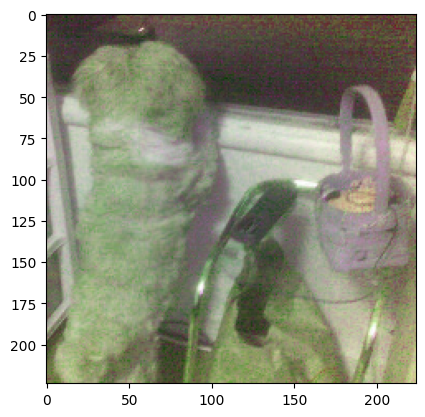

In [9]:
test_image = preprocess_image(image)
plt.imshow(test_image)
test_image.shape

In [10]:
# Create Image Generator
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_image,
    validation_split=0.0
)

In [11]:
# #Build the generators
# CLASS_NUM = 1000

# train_generator = generator.flow_from_directory(
#     "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train",
#     target_size = (224,224),
#     batch_size = BATCH_SIZE,
# #     subset='training',
#     class_mode = 'categorical'
# )

# # validation_generator = generator.flow_from_directory(
# #     "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train",
# #     target_size = (224,224),
# #     batch_size = BATCH_SIZE,
# #     subset='validation',
# #     class_mode = 'categorical'
# # )

# # test_generator = generator.flow_from_directory(
# #     "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/",
# #     target_size = (224,224),
# #     batch_size = BATCH_SIZE,
# #     classes = ["test"],
# #     class_mode = None
# # )

# Model Design

In general, the model architecture resembles the model from the paper pretty well, even though some details may still be missing.

In [12]:
# Design model
def build_model():
    model = keras.models.Sequential([
    
        # 1st convolutional block
        layers.Conv2D(input_shape=(224,224,3), filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
        # 2nd convolutional block
        layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
        
        # 3rd convolutional block
        layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
        # 4th convolutional block
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
        # 5th convolutional block
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
        # Classifier head
        layers.Flatten(),
        layers.Dense(4096, activation=ACTIVATION),
        layers.Dropout(rate=0.5),
        layers.Dense(4096, activation=ACTIVATION),
        layers.Dropout(rate=0.5),
        layers.Dense(CLASS_NUM, activation="softmax")
    ])
    return model

In [13]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    model = build_model()

    # Define optimiser
    sgd_optimiser = keras.optimizers.experimental.SGD(
        learning_rate=0.01,
        momentum=0.90,
        nesterov=False,
        weight_decay=0.0005
    )

    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

To test that the model works, we train it for a few epochs. Ideally, we will train the model on the full dataset when once it resembles the model from the paper in terms of parameter number. 

In [14]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=2,
#     batch_size=BATCH_SIZE,
#     verbose=True,
#     callbacks=[LR_Decay],
# #     validation_data=validation_generator
# )

# # Store training history as a dataframe
# history_df = pd.DataFrame(history.history)

# print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
# print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

The model contains 128778627 trainable parameters, which aligns pretty well with the 33 million in the paper. Our model may still lack some element responsible for the missing 4 million parameters.

In [15]:
# # Visualise loss
# history_df.loc[:, "loss"].plot(title="Loss")

In [16]:
# # Visualise accuracy
# history_df.loc[:, "categorical_accuracy"].plot(title="Accuracy")

# Transfer Learning

The next step involves building a deeper ConvNet by:
1. taking the pretrained base from the previous section,
2. enriching it with new untrained convolutional layers and
3. attaching it to a new untrained classification head

By transferring the learnt weight from our previous model, we can build more complex and deeper ConvNets without too much computational burden. In particular, here we aim to reproduce the following four architectures from _Zimonyan & Zisserman 2015_:
- 13-layer ConvNet
- 16-layer ConvNet (with 1-by-1 filters)
- 16-layer ConvNet (with 3-by-3 filters)
- 19-layer ConvNet

In the following cell, we pretend that the previously trained model is stored in a keras file to show how pretrained models can be imported into a notebook.

In [17]:
# # Define model file
# model_file = f"/kaggle/working/11layer_model.keras"

# # Save model into file for replication purposes
# model.save(model_file)